In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
from matplotlib.collections import LineCollection
from scipy.interpolate import CubicSpline
import matplotlib.colors as mcolors

# import seaborn as sns

In [2]:
order_file = glob.glob("ord*.csv")[0]
part_file = glob.glob("par*.csv")[0]

In [3]:
order_file

'order_parameters_L30_T1000_N450_eta0.1.csv'

In [4]:
order_param_df = pd.read_csv(order_file)

In [5]:
particles_df = pd.read_csv(part_file)

In [6]:
figsize_dims = 6

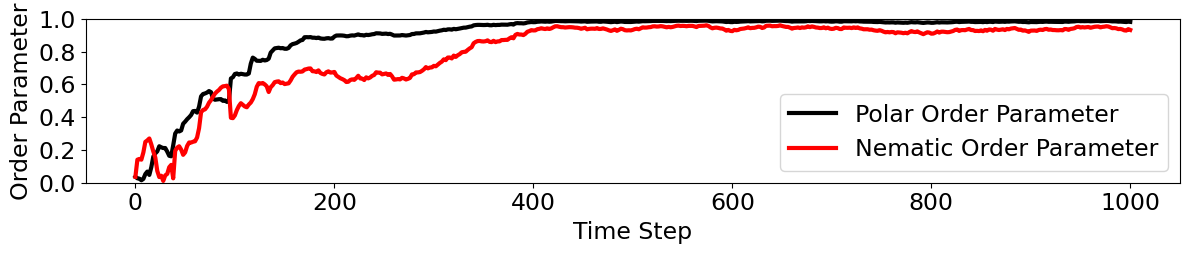

In [7]:
plt.figure(figsize=(figsize_dims*2, 0.44/2*figsize_dims*2))
plt.plot(order_param_df["time_step"], order_param_df["P_t"], label="Polar Order Parameter", color="black", linewidth=3)
plt.plot(order_param_df["time_step"], order_param_df["S_t"], label="Nematic Order Parameter", color="red", linewidth=3)
plt.xlabel("Time Step", fontsize=17)
plt.ylabel("Order Parameter", fontsize=17)
plt.ylim(0, 1)

plt.legend(fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.tight_layout()
plt.savefig("order_param.png", dpi=300)

In [50]:
time_snapshots = [0, 100, 300, 1000]

In [51]:
def plot_particle_trajectories(particles_df, particle_ids_random, times, L):
    """
    Plot trajectories of selected particles with quivers at the last time step.
    Excludes particles that cross the periodic boundary.
    
    Parameters:
    - particles_df: DataFrame containing particle trajectories
    - particle_ids_random: List of particle IDs to plot
    - times: Array of time steps in ascending order [t-n, ..., t-1, t]
    - L: Domain size
    """
    # Create figure
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Set up colormap for time evolution
    cmap = plt.cm.turbo
    norm = mcolors.Normalize(vmin=min(times), vmax=max(times))
    
    # Create a color array for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    for particle_id in particle_ids_random:
        # Get data for this particle at the specified times
        particle_data = particles_df[(particles_df['particle_id'] == particle_id) & 
                                    (particles_df['time_step'].isin(times))]
        
        if len(particle_data) < 2:  # Need at least 2 points for interpolation
            continue
            
        # Sort by time step to ensure chronological order
        particle_data = particle_data.sort_values('time_step')
        
        # Extract coordinates and time data
        t_data = np.array(particle_data['time_step'])
        x_data = np.array(particle_data['x'])
        y_data = np.array(particle_data['y'])
        
        # Check if this particle crosses a boundary
        crosses_boundary = False
        for i in range(1, len(x_data)):
            dx = abs(x_data[i] - x_data[i-1])
            dy = abs(y_data[i] - y_data[i-1])
            if dx > L/2 or dy > L/2:
                crosses_boundary = True
                break
        
        if crosses_boundary:
            continue  # Skip this particle
            
        # Create more points for smooth interpolation
        t_fine = np.linspace(t_data.min(), t_data.max(), 20)
        
        # Cubic spline interpolation
        cs_x = CubicSpline(t_data, x_data)
        cs_y = CubicSpline(t_data, y_data)
        
        x_fine = cs_x(t_fine)
        y_fine = cs_y(t_fine)
        
        # Create colored segments based on time
        points = np.array([x_fine, y_fine]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Create a LineCollection for efficient colored line plotting
        lc = LineCollection(segments, cmap=cmap, norm=norm)
        lc.set_array(t_fine[:-1])  # Set colors based on time
        lc.set_linewidth(2)
        ax.add_collection(lc)
        
        # Add quiver for the last time step
        last_point = particle_data[particle_data['time_step'] == times[-1]]
        if not last_point.empty:
            x, y, theta = last_point[['x', 'y', 'theta']].values[0]
            dx, dy = np.cos(theta), np.sin(theta)
            ax.quiver(x, y, dx, dy, color='black', scale=50, width=0.004, headwidth=3, headlength=4)
    
    # Add colorbar and labels
    # cbar = fig.colorbar(sm, ax=ax, label='Time Step')
    # add a textbox at top right corner which shows the time step
    # ax.text(0.95, 0.95, f't = {times[-1]}', transform=ax.transAxes,
    #         fontsize=12, verticalalignment='top', horizontalalignment='right',
    #         bbox=dict(facecolor='lightgrey', alpha=0.5, edgecolor='lightgrey'))
    # Set plot limits and labels
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    # ax.set_xlabel('X Position')
    # ax.set_ylabel('Y Position')
    # ax.set_title('Particle Trajectories (Excluding Boundary Crossers)')
    ax.set_aspect('equal')
    # ax.grid(True, alpha=0.3)
    # remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.tight_layout()
    return fig, ax

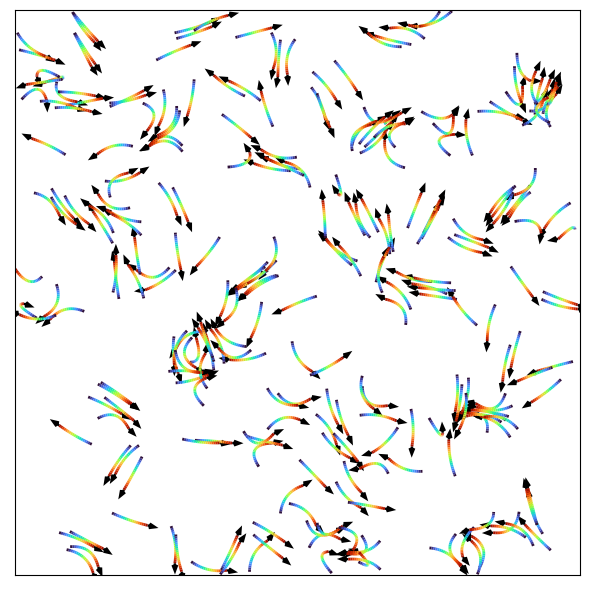

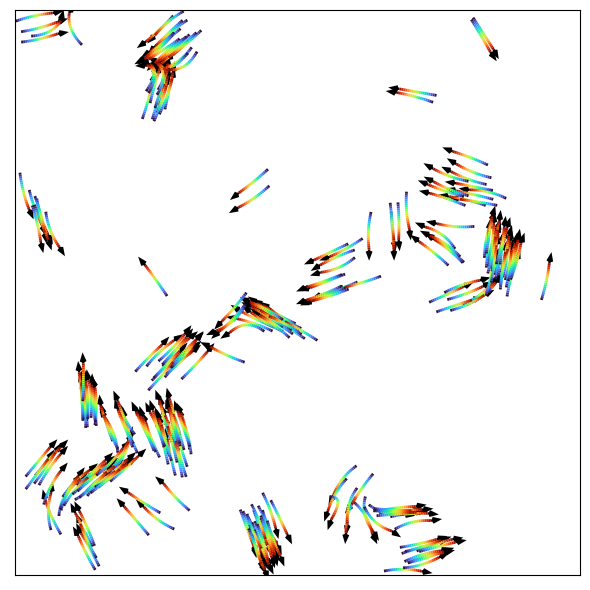

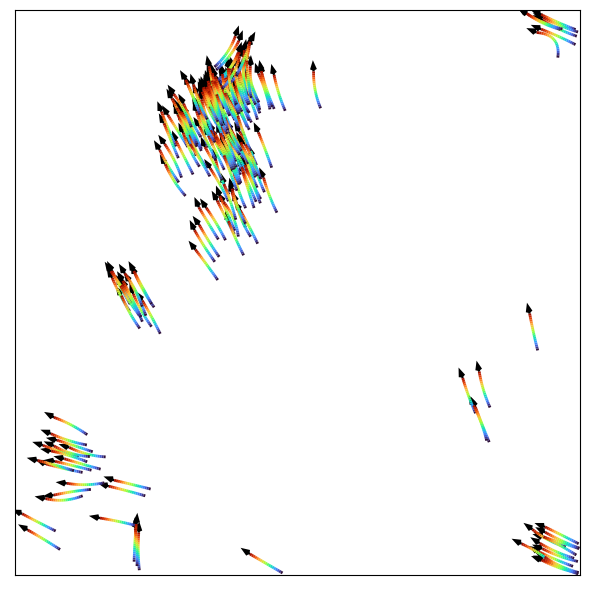

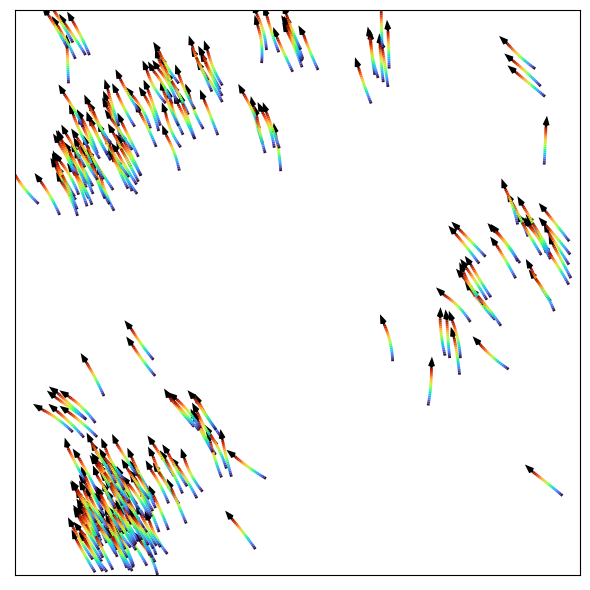

In [53]:
n_snapshots = 3
time_step = 2
n_particles = 300
random_particle_ids = np.random.choice(particles_df["particle_id"].unique(), size=n_particles, replace=False)
random_particle_ids = sorted(random_particle_ids)
times = np.array([0, 40, 200, 990]) + n_snapshots * time_step
for t in times:
    time_array = t - np.arange(n_snapshots) * time_step
    time_array = np.flip(time_array)
    fig, ax = plot_particle_trajectories(particles_df, random_particle_ids, time_array, L=30)
    plt.savefig(f"particle_trajectories_t{t}.png", dpi=300)